# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines Finding** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import sklearn
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import svm, grid_search
import pickle

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

%matplotlib inline

C:\Users\kabugon\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kabugon\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Helper Functions

In [2]:
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = image * 255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    img = img * 255#new
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    confidence = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        conf = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            confidence.append(conf)
    #8) Return windows for positive detections
    return on_windows, confidence
    

In [5]:

def add_heat(heatmap, bbox_list, confidence):
    # Iterate through list of bboxes
    for box, conf in zip(bbox_list, confidence):
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += conf

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        xsize = np.max(nonzerox) - np.min(nonzerox)
        ysize = np.max(nonzeroy) - np.min(nonzeroy)
        aspect = xsize / ysize

        if 4.0 > aspect > 0.5 and 30 < xsize  and 30 < ysize:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0.6, 1.0, 0.6), 6)
        
        
    # Return the image
    return img


## Train and Test Data

In [6]:
# # Read in cars and notcars
cars1    = glob.glob('./vehicles/KITTI_extracted/train/*.png')
cars2    = glob.glob('./vehicles/GTI_Right/train/*.png')
cars3    = glob.glob('./vehicles/GTI_MiddleClose/train/*.png')
cars4    = glob.glob('./vehicles/GTI_Left/train/*.png')
cars5    = glob.glob('./vehicles/GTI_Far/train/*.png')
cars_train = cars1 + cars2 + cars3 + cars4 + cars5
cars_train_size = len(cars_train)
print(cars_train_size)

cars6    = glob.glob('./vehicles/KITTI_extracted/test/*.png')
cars7    = glob.glob('./vehicles/GTI_Right/test/*.png')
cars8    = glob.glob('./vehicles/GTI_MiddleClose/test/*.png')
cars9    = glob.glob('./vehicles/GTI_Left/test/*.png')
cars10   = glob.glob('./vehicles/GTI_Far/test/*.png')
cars_test = cars6 + cars7 + cars8 + cars9 + cars10
cars_test_size = len(cars_test)
print(cars_test_size)

notcars1 = glob.glob('./non-vehicles/GTI/train/*.png')
notcars2 = glob.glob('./non-vehicles/Extras/train/*.png')
notcars_train = notcars1 + notcars2
notcars_train_size = len(notcars_train)
print(notcars_train_size)

notcars3 = glob.glob('./non-vehicles/GTI/test/*.png')
notcars4 = glob.glob('./non-vehicles/Extras/test/*.png')
notcars_test = notcars3 + notcars4
notcars_test_size = len(notcars_test)
print(notcars_test_size)

cars    = cars_train + cars_test
notcars = notcars_train + notcars_test
cars_size = len(cars)
notcars_size = len(notcars)
print(len(cars))
print(len(notcars))


6965
1827
7276
1692
8792
8968


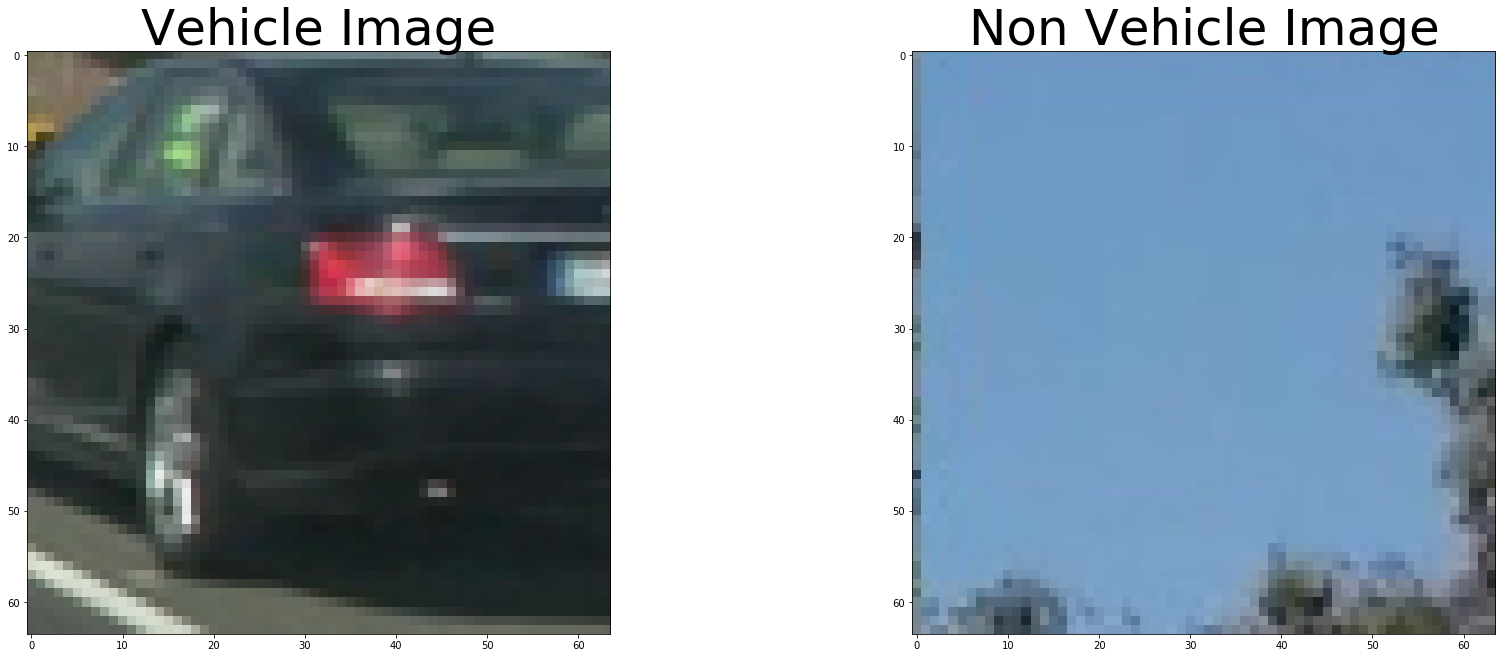

In [7]:
#image example

carimage    = mpimg.imread(cars2[0])
notcarimage = mpimg.imread(notcars2[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(carimage)
ax1.set_title('Vehicle Image', fontsize=50)
ax2.imshow(notcarimage)
ax2.set_title('Non Vehicle Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('car_notcar_example.jpg')



## Training

In [8]:
#parameters
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into training and test sets
X_train = np.vstack((X[0:cars_train_size], X[cars_size:cars_size+notcars_train_size])).astype(np.float64)
X_test  = np.vstack((X[cars_train_size:cars_size], X[cars_size+notcars_train_size:])).astype(np.float64)
y_train = np.hstack((y[0:cars_train_size], y[cars_size:cars_size+notcars_train_size])).astype(np.float64)
y_test  = np.hstack((y[cars_train_size:cars_size], y[cars_size+notcars_train_size:])).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#svc = svm.SVC(kernel='rbf', C=0.5, gamma=0.00390625)
svc = LinearSVC(C=0.001953125)
#svc = svm.SVC(kernel='rbf', C=1, gamma=1)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print(' Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))



Using: 12 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 1392
1.87 Seconds to train SVC...
 Test Accuracy of SVC =  0.979


## Detection Example

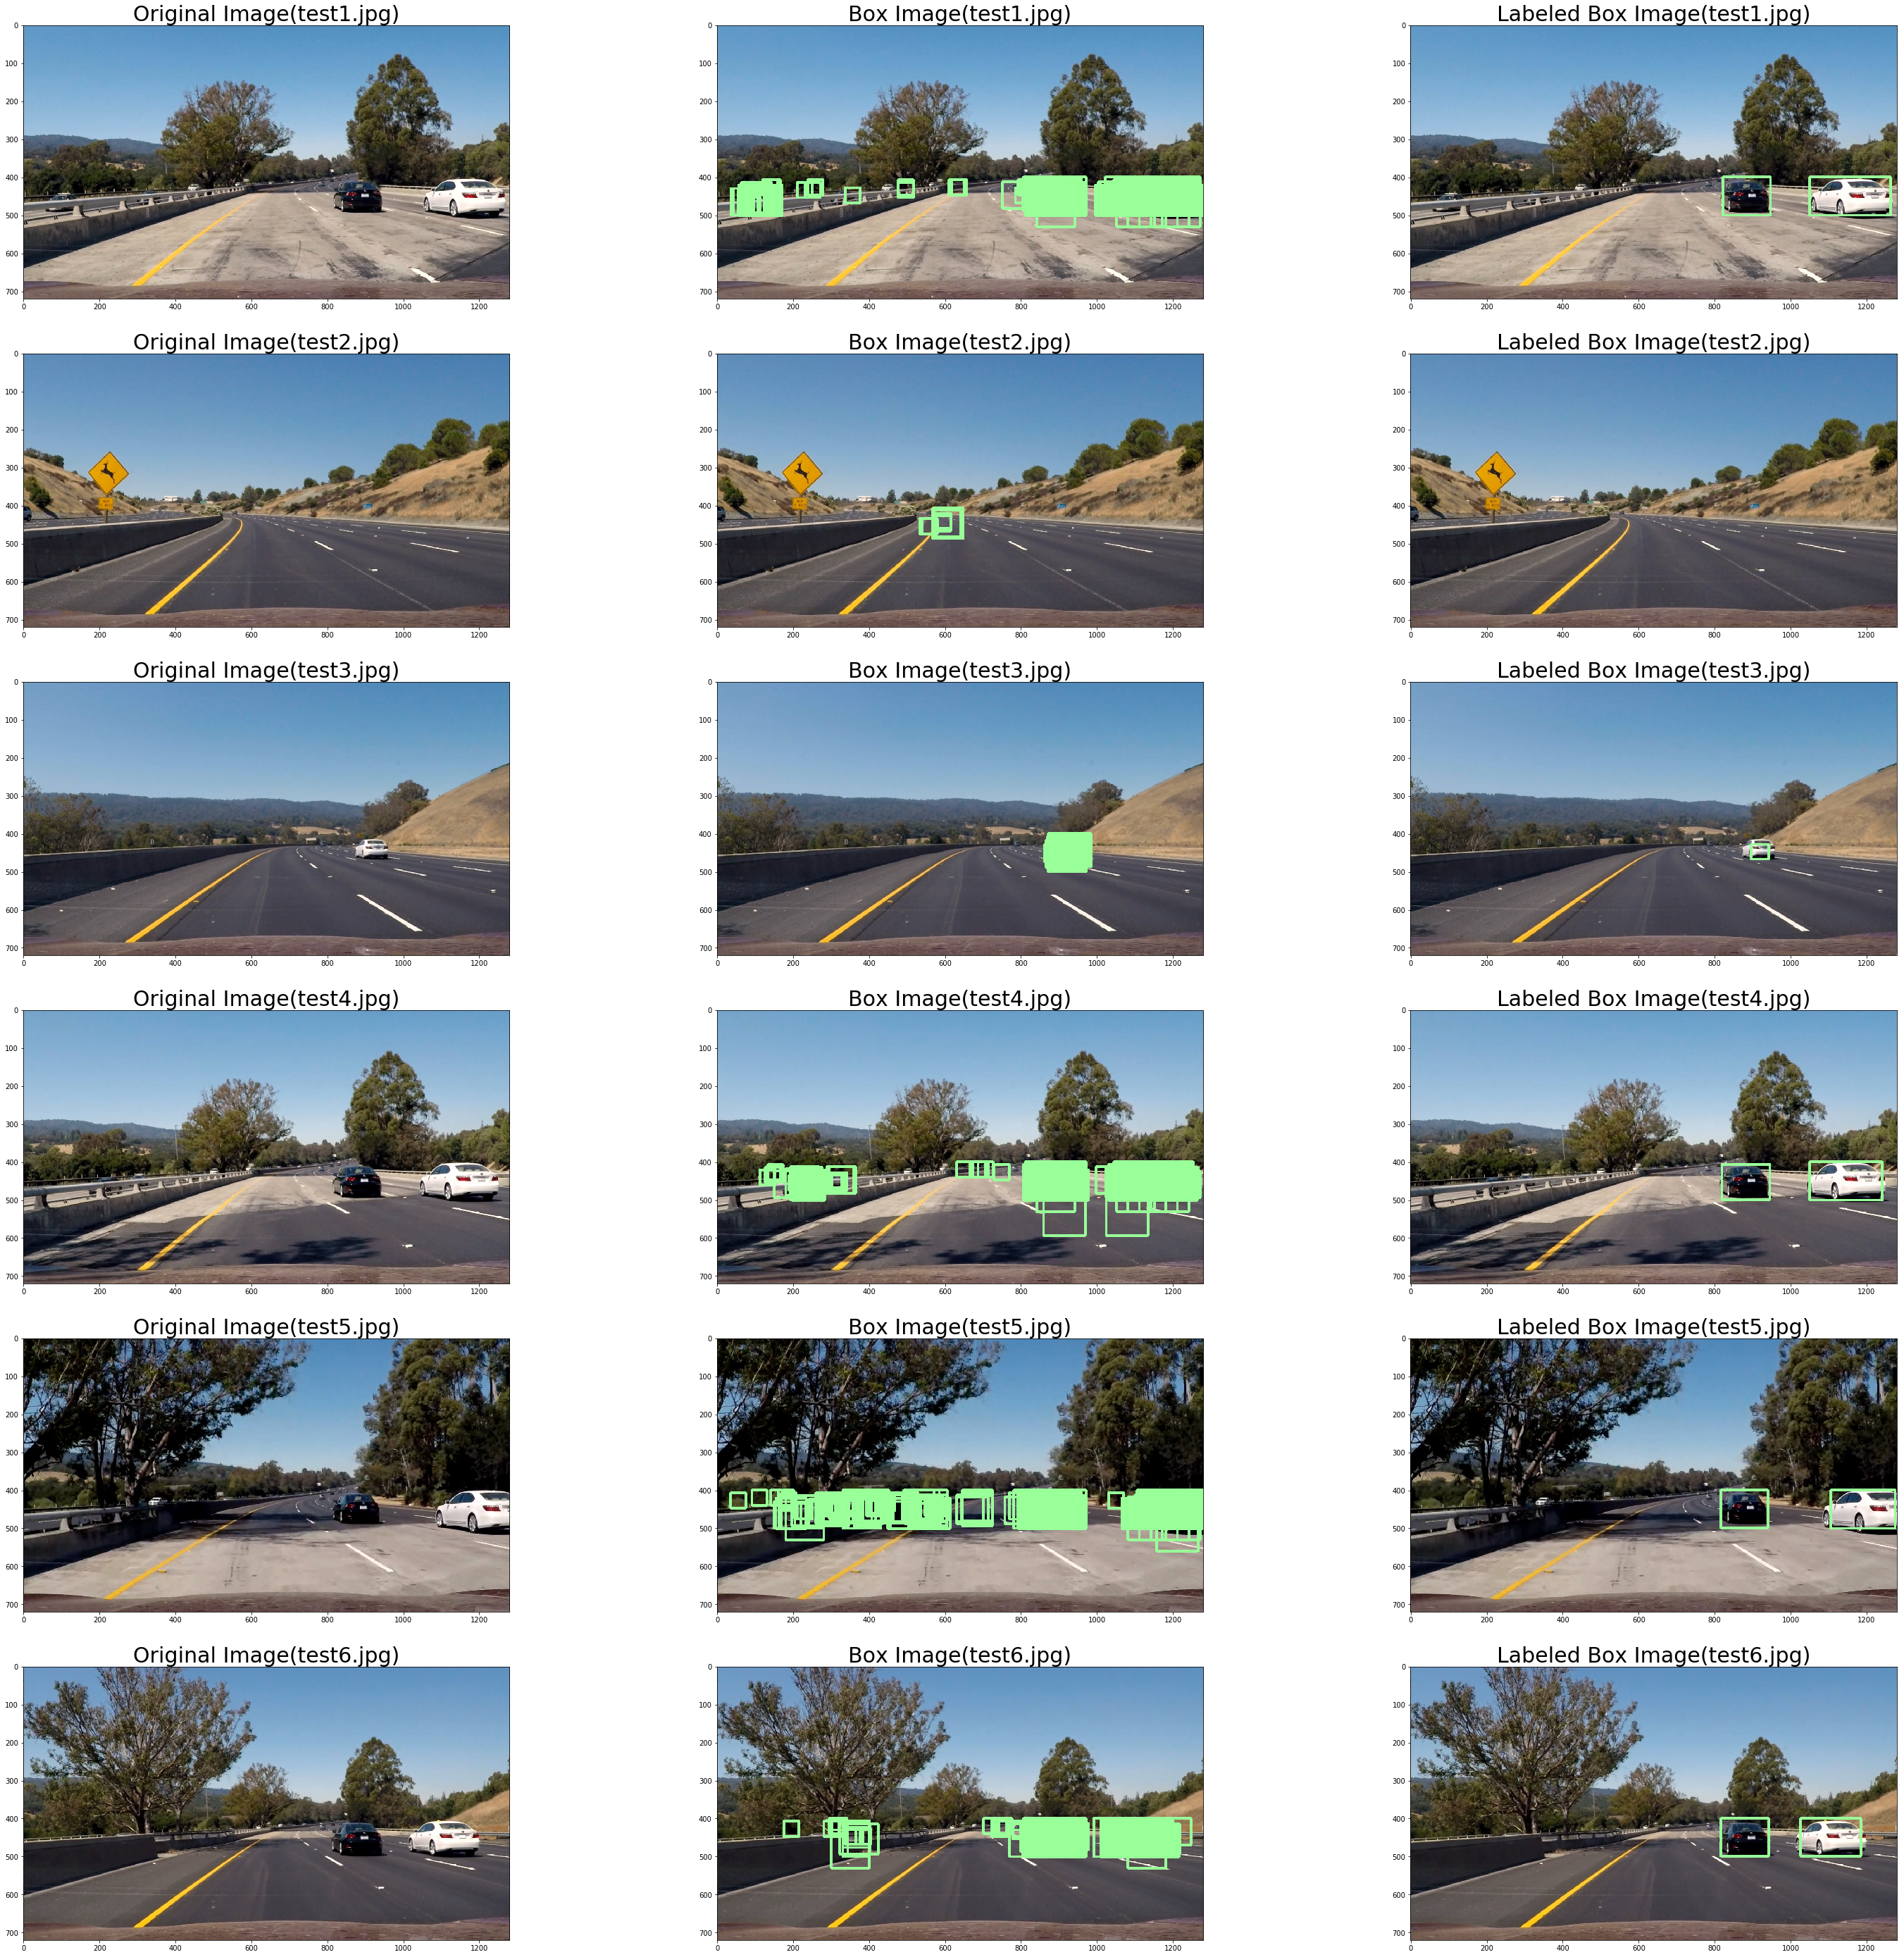

In [9]:
#window result

windows_result_imgs = glob.glob('./test_images/*.jpg')
f, ax = plt.subplots(len(windows_result_imgs), 3, figsize=(50, 50))
#f.tight_layout()

i=0
for w_img in windows_result_imgs:
    image = mpimg.imread(w_img)
    image = image / 255.0
    image = image.astype(np.float32)

    draw_image = np.copy(image)

    hot_windows_list = []
    confidence_list = []

    window_size_list  = [(40, 40), (70, 70), (80, 80), (100, 100), (110, 110)]
    overlap_list      = [(0.8, 0.8), (0.9, 0.9), (0.9, 0.9), (0.7, 0.7), (0.7, 0.7)]
    y_start_stop_list = [[400, 475], [400, 500], [400, 500], [400, 550], [450, 650]]

    for window_size, overlap, y_start_stop in zip(window_size_list, overlap_list, y_start_stop_list):
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=window_size, xy_overlap=overlap)

        hot_windows, confidence = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       

        hot_windows_list = hot_windows_list + hot_windows
        confidence_list = confidence_list + confidence


    draw_img = draw_boxes(draw_image, hot_windows_list, color=(0.6, 1.0, 0.6), thick=6)                    

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list = hot_windows_list
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list, confidence_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 17)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_labeled_img = draw_labeled_bboxes(np.copy(image), labels)

    ax[i,0].imshow(image)
    ax[i,0].set_title('Original Image(test' + str(i+1) + '.jpg)', fontsize=30)
    ax[i,1].imshow(draw_img)
    ax[i,1].set_title('Box Image(test' + str(i+1) + '.jpg)', fontsize=30)
    ax[i,2].imshow(draw_labeled_img)
    ax[i,2].set_title('Labeled Box Image(test' + str(i+1) + '.jpg)', fontsize=30)


    i = i + 1

plt.savefig('windows_result.jpg')


## Detection for Video

In [10]:
prev_heat = np.zeros_like(heat)

def process_image(image):
    global prev_heat    
    
    image = image / 255.0
    image = image.astype(np.float32)

    result = np.copy(image)

    hot_windows_list = []
    confidence_list = []

    window_size_list  = [(40, 40), (70, 70), (80, 80), (100, 100), (110, 110)]
    overlap_list      = [(0.8, 0.8), (0.9, 0.9), (0.9, 0.9), (0.7, 0.7), (0.7, 0.7)]
    y_start_stop_list = [[400, 475], [400, 500], [400, 500], [400, 550], [450, 650]]

    for window_size, overlap, y_start_stop in zip(window_size_list, overlap_list, y_start_stop_list):
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=window_size, xy_overlap=overlap)

        hot_windows, confidence = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       

        hot_windows_list = hot_windows_list + hot_windows
        confidence_list = confidence_list + confidence
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list = hot_windows_list    

    # Add heat to each box in box list
    heat = add_heat(heat,box_list, confidence_list)    
    
    # Apply threshold to help remove false positives
#    heat_th = apply_threshold(heat, 5)#iikanji, gomi hiroimakuri
    heat_th = apply_threshold(heat, 17)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_th, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    result = draw_labeled_bboxes(result, labels) * 255
    result = result.astype(np.uint8)

    return result

In [11]:
output = './project_video_output.mp4'

clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
#clip1 = VideoFileClip("./harder_challenge_video.mp4")
#clip = clip1.fl_image(process_image).subclip(23,30) #NOTE: this function expects color images!!
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [3:10:47<00:08,  8.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 3h 10min 48s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))